In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
from matplotlib import rc
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import

name = '_DIM'

path = '/home/julie/analysis/bilayers/PM_5DIM/'
path_data = path
path_res = '/home/julie/analysis/bilayers/res_DIM/'
fgro = 'run_PM_5DIM.gro'
fxtc = 'run_PM_5DIM_s10_center_droplet2.xtc'

In [3]:
# load gro and xtc files
u = mda.Universe( path_data+fgro, path_data+fxtc)

In [4]:
# number of frames
len(u.trajectory)

2501

In [5]:
sel_all = u.select_atoms("all")

In [6]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all, gui=True)
#v.frame = 6395
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

A Jupyter Widget

In [7]:
#v.download_image(filename='screenshot.png', factor=4, antialias=True, trim=False, transparent=False)

# boucle pour travailler sur des frames de la simu

tmes = 400

str_sel= "all and (name PO4 or name GM1)"

            
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM1')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)
            
for ts in u.trajectory:
     if (ts.frame%tmes == 0 and ts.frame>=t_start and ts.frame==6400):
            print(ts.frame)
            
            patch = u.select_atoms(str_sel).positions
            
            Lo = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DPPC").positions
            Ld = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DIPC").positions
            GM1 = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name AM1").positions
            chol = leaflet1.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name ROH").positions

            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
            plt.scatter(Lo[:,1]/N, -Lo[:,0]/N, marker='.', c='yellow', s=2)
            plt.scatter(Ld[:,1]/N, -Ld[:,0]/N, marker='.', c='b', s=2)
            plt.scatter(GM1[:,1]/N, -GM1[:,0]/N, marker='+', c='g', s=2)
            plt.savefig(pathd+'t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            #pour enregistrer les plots


In [8]:
# needed functions for the local curvature computation

def F_neigh(n) :
    neigh[0] = n
    i=n%N
    j=int(n/N)
    ip1=(i+1)%N
    im1=(i-1)%N
    jp1=(j+1)%N
    jm1=(j-1)%N
    neigh[1] = ip1+N*j
    neigh[2] = im1+N*j
    neigh[3] = i+N*jm1
    neigh[4] = i+N*jp1

def Lap(n) :
    lap = ( h[neigh[4]]+h[neigh[3]]-2*h[neigh[0]] ) / dx**2 + ( h[neigh[1]]+h[neigh[2]]-2*h[neigh[0]] ) / dy**2
    return(lap)


In [9]:
time_simu = 2.5 # microseconds
nb_frames_simu = 2500

In [10]:
# Leaflet separation

u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

sel_tot = "all and name PO4"
l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 2432
number of lipids in the upper leaflet: 1216 + number of lipids in the lower leaflet:1216 
= 2432


In [11]:
sel_DPPC = "name PO4 and resname POPC"
l1 = u.select_atoms(sel_DPPC).positions

sel_DIPC = "name PO4 and resname POPE"
l2 = u.select_atoms(sel_DIPC).positions

sel_chol = "name ROH"
l3 = u.select_atoms(sel_chol).positions

sel_DIM = "all and resname DIM"
l4 = u.select_atoms(sel_DIM).positions

print(len(l1))
print(len(l2))
print(len(l3))
print(len(l4))

1216
912
608
3648


In [12]:
tmes = 10
t_start = 2

N = 15
threshold = 0.5 # composition threshold from which the box is considered Lo, below it is considered Ld

In [13]:
#loop to compute all the observables through time

t = []

C_t_Lo = []
C_t_Ld = []

# in the bubble zone
C_t_Lo_b = []
C_t_Ld_b = []

thick_t_Lo = []
thick_t_Ld = []

cov_c_t = []


# averaged around the bubble
l_bubble = 7
r_bubble = np.int(np.floor(l_bubble/2))
M_bubble_C_t = np.zeros((l_bubble,l_bubble))
M_bubble_phi_bin_t = np.zeros((l_bubble,l_bubble))


for ts in u.trajectory:
    
    # boxes that do not contain any PC molecule
    empty0 = 0
    empty1 = 0
    
    if (ts.frame%tmes == 0 and ts.frame>=t_start):
            
            print(ts.frame)
            t.append(ts.frame/ (nb_frames_simu/time_simu))
            
            patch = u.select_atoms(sel_tot).positions
            
            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
           
            
            # leaflet 0 -----------------------------------------------------------------------------------------------------
            
            bary0 = []

            Mphi0_Lo = np.zeros((N,N)) # ratio DPPC / all PC in each box

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b0=leaflet0.select_atoms(sel).centroid().tolist()
                    bary0.append(b0)

                    # PC composition rates in each box
                    sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                    tot0PC= leaflet0.select_atoms(sel_totPC).positions
                    n_tot0PC=len(tot0PC) # total number of PC

                    sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname POPC"
                    Lo0= leaflet0.select_atoms(sel_Lo).positions
                    n_Lo0=len(Lo0) # number of molecules of the Lo phase (POPC here)
                    
                    if  n_tot0PC!=0:
                        phi0_Lo=n_Lo0/n_tot0PC
                        Mphi0_Lo[i,j]=phi0_Lo
                    else :
                        empty0 += 1
                        print('leaflet 0, empty box: i=%d and j=%d' % (i,j))

            bary0=np.array(bary0)
            
            # leaflet 1 -----------------------------------------------------------------------------------------------------
            
            bary1 = []

            Mphi1_Lo = np.zeros((N,N))

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy

                    # barycenter of all molecules in each box
                    sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    b1=leaflet1.select_atoms(sel).centroid().tolist()
                    bary1.append(b1)

                    # composition rates in each box
                    sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                    tot1PC= leaflet1.select_atoms(sel_totPC).positions
                    n_tot1PC=len(tot1PC) # total number of PC

                    sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname POPC"
                    Lo1= leaflet1.select_atoms(sel_Lo).positions
                    n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)

                    if  n_tot1PC!=0:
                        
                        phi1_Lo=n_Lo1/n_tot1PC
                        Mphi1_Lo[i,j]=phi1_Lo
                    else :
                        empty1 += 1
                        print('leaflet 1,empty box: i=%d and j=%d' % (i,j))


            bary1=np.array(bary1)
            #--------------------------------------------------------------------------------------------------------------------------------
            
            # mean (between the 2 leaflets) composition field
            Mphi_mean = (Mphi0_Lo+Mphi1_Lo)/2
            
##################################################################################################################################  
            # compute the local thickness
    
            bary0.shape=(N,N,3)
            bary1.shape=(N,N,3)

            diffz=bary0[:,:,2]-bary1[:,:,2]

            bary0.shape=(N*N,3)
            bary1.shape=(N*N,3)
            
##################################################################################################################################  
            # compute the local curvature
            
            neigh = [0,0,0,0,0]
            h=bary0[:,2]         # for the upper leaflet
            laplacian = []
            
            for i in range(N*N) :
                F_neigh(i)
                laplacian.append(Lap(i))
                
            C = np.array(laplacian)
            C.shape=(N,N)

##################################################################################################################################  
            # binary composition and local thickness and curvature associated to Lo phase and Lo boundary
# LEAFLET 0       
            # Lo phase binarization
            Mphi0_bin = np.zeros((N,N))

            for i in range(N):
                for j in range(N):
                    if Mphi0_Lo[i,j]>= threshold :
                        Mphi0_bin[i,j]=1
# LEAFLET 1       
            # Lo phase binarization
            Mphi1_bin = np.zeros((N,N))

            for i in range(N):
                for j in range(N):
                    if Mphi1_Lo[i,j]>= threshold :
                        Mphi1_bin[i,j]=1

                        
##################################################################################################################################  
            # get the bubble zone
                
            diffz.shape=(N*N)

            max_val = 0
            max_ind = 0

            for i in range(N*N):
                if(diffz[i])>=max_val:
                    max_val = diffz[i]
                    max_ind = i

            max_ind_x = max_ind//N
            max_ind_y = max_ind%N

            diffz.shape=(N,N)
            
            M_bubble_C0 = np.zeros((l_bubble,l_bubble))
            M_bubble_phi0 = np.zeros((l_bubble,l_bubble))
            
            cpt = 0
            for i in range(N):
                for j in range(N):
                    if np.abs(i-max_ind_x)<=r_bubble and np.abs(j-max_ind_y)<=r_bubble :
                        M_bubble_C0[cpt//l_bubble, cpt%l_bubble] = C[i,j]
                        M_bubble_phi0[cpt//l_bubble, cpt%l_bubble] = Mphi0_bin[i,j]
                        cpt += 1 
            M_bubble_C_t = M_bubble_C_t + M_bubble_C0
            M_bubble_phi_bin_t = M_bubble_phi_bin_t + M_bubble_phi0
                
##################################################################################################################################  
            # if the phase of the box is Lo then the thickness is averaged
            thick_Lo = []
            thick_Ld = []
            for i in range(N):
                for j in range(N):
                    if Mphi0_bin[i,j] == 1 :
                        thick_Lo.append(diffz[i,j])
                    else:
                        thick_Ld.append(diffz[i,j])
                        
            thick_t_Lo.append(np.mean(thick_Lo))
            thick_t_Ld.append(np.mean(thick_Ld))
            
            # the curvature is averaged depending on the phase of the box
            C_Lo = []
            C_Ld = []
            
            for i in range(N):
                for j in range(N):
                    if Mphi0_bin[i,j] == 1 :
                        C_Lo.append(C[i,j])
                    else:
                        C_Ld.append(C[i,j])
                        
            C_t_Lo.append(np.mean(C_Lo))
            C_t_Ld.append(np.mean(C_Ld))
            
            
            # the curvature is averaged depending on the phase of the box in the bubble zone
            C_Lo_b = []
            C_Ld_b = []
            
            for i in range(l_bubble):
                for j in range(l_bubble):
                    if M_bubble_phi0[i,j] == 1 :
                        C_Lo_b.append(M_bubble_C0[i,j])
                    else:
                        C_Ld_b.append(M_bubble_C0[i,j])
                        
            C_t_Lo_b.append(np.mean(C_Lo_b))
            C_t_Ld_b.append(np.mean(C_Ld_b))
    
##################################################################################################################################  
            # compute the correlations (covariance) 
            
            # composition and local curvature (of the upper leaflet)
            sum = 0
            for i in range(0,N):
                for j in range(0,N):
                    sum = sum + ( C[i,j]*Mphi0_bin[i,j] - np.mean(C)*np.mean(Mphi0_bin) ) / np.std(C)/np.std(Mphi0_bin)
            cov_c = sum/N**2
            cov_c_t.append(cov_c)
                       
##################################################################################################################################  
            # plot                        
            s = 10 # fontsize
            plt.subplot(221)
            plt.imshow(Mphi0_Lo)
            plt.colorbar()
            plt.title('Composition (DPPC ratio, upper leaflet)', fontsize=s)
            plt.subplot(222)
            plt.imshow(diffz)
            plt.colorbar()
            plt.title('Local thickness ($\AA$)', fontsize=s)
            plt.subplot(223)
            plt.imshow(Mphi0_bin)
            plt.colorbar()
            plt.title('Upper leaflet binary composition \n(1 is Lo, 0 is Ld)', fontsize=s)
            plt.subplot(224)
            plt.imshow(-C)
            plt.colorbar()
            plt.title('Upper leaflet local curvature ($\AA^{-1}$)', fontsize=s)
            plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9, hspace = 0.5)
            plt.savefig(path_res+'compo-thick_Lo_curv'+name+'_t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            plt.clf()
            
            print('empty boxes leaflet 0: %d' % empty0)
            print('empty boxes leaflet 1: %d' % empty1)

10
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
20
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
30
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
40
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
50
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
60
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
70
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
80
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
90
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
100
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
110
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
120
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
130
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
140
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
150
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
160
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
170
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
180
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
190
empty boxes leaflet 0: 0
empty bo

empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1520
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1530
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1540
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1550
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1560
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1570
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1580
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1590
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1600
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1610
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1620
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1630
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1640
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1650
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1660
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1670
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1680
empty boxes leaflet 0: 0
empty boxes leaflet 1: 0
1690
empty boxe

<Figure size 432x288 with 0 Axes>

In [14]:
nb_mes = (nb_frames_simu-t_start)//tmes
print(nb_mes)

249


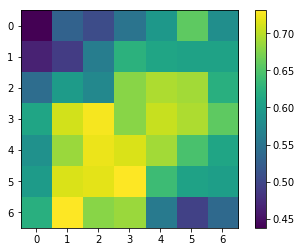

In [15]:
plt.imshow(M_bubble_phi_bin_t/nb_mes)
plt.colorbar()
plt.savefig(path_res+'averaged_compo'+name+'3.pdf', format='pdf',bbox_inches='tight')

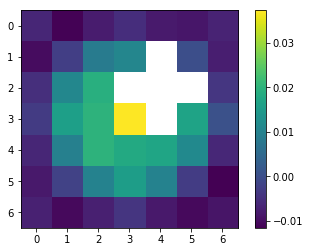

In [16]:
plt.imshow(-M_bubble_C_t/nb_mes)
plt.colorbar()
plt.savefig(path_res+'averaged_curvature'+name+'3.pdf', format='pdf',bbox_inches='tight')

print(np.mean(C_t_core_Lo)) = -0.0005705317487332791

In [30]:
# IPBS
name = '_DIM'
path_res = '/home/julie/analysis/bilayers/res_DIM/'

In [31]:
np.save(path_res+'thick_t_Lo'+name+'.npy', thick_t_Lo)
np.save(path_res+'thick_t_Ld'+name+'.npy', thick_t_Ld)
np.save(path_res+'C_t_Lo'+name+'.npy', C_t_Lo)
np.save(path_res+'C_t_Ld'+name+'.npy', C_t_Ld)
np.save(path_res+'cov_c_t'+name+'.npy', cov_c_t)

In [19]:
# in real time units

t_start_r = t_start / (nb_frames_simu/time_simu)
tmes_r = tmes / (nb_frames_simu/time_simu)

In [20]:
# in real time units

t=np.arange(t_start,nb_frames_simu,tmes)/ (nb_frames_simu/time_simu)

In [21]:
xprint = t_start_r+(max(t)-t_start_r)/2

In [22]:
t_av = np.arange(10000,nb_frames_simu,tmes*100)/ (nb_frames_simu/time_simu)

l0_av = np.zeros(10)
l0_err = np.zeros(10)

l0_av = l0_av+np.mean(l0[500:])
l0_err = l0_err+np.std(l0[500:])


# Thickness

In [55]:
l0 = np.load(path_res0+'thick_t_Lo'+name0+'.npy')
l5 = np.load(path_res5+'thick_t_Lo'+name5+'.npy')
l10 = np.load(path_res10+'thick_t_Lo'+name10+'.npy')

In [77]:
stack = 50

l0_lis = []
for i in range(len(l0)-stack):
    sum_val = 0
    for j in range(stack):
        sum_val = sum_val+l0[i+j]
    l0_lis.append(sum_val/stack)
    
l5_lis = []
for i in range(len(l5)-stack):
    sum_val = 0
    for j in range(stack):
        sum_val = sum_val+l5[i+j]
    l5_lis.append(sum_val/stack)
    
l10_lis = []
for i in range(len(l10)-stack):
    sum_val = 0
    for j in range(stack):
        sum_val = sum_val+l10[i+j]
    l10_lis.append(sum_val/stack)

In [78]:
l0_lis = np.array(l0_lis)
l5_lis = np.array(l5_lis)
l10_lis = np.array(l10_lis)

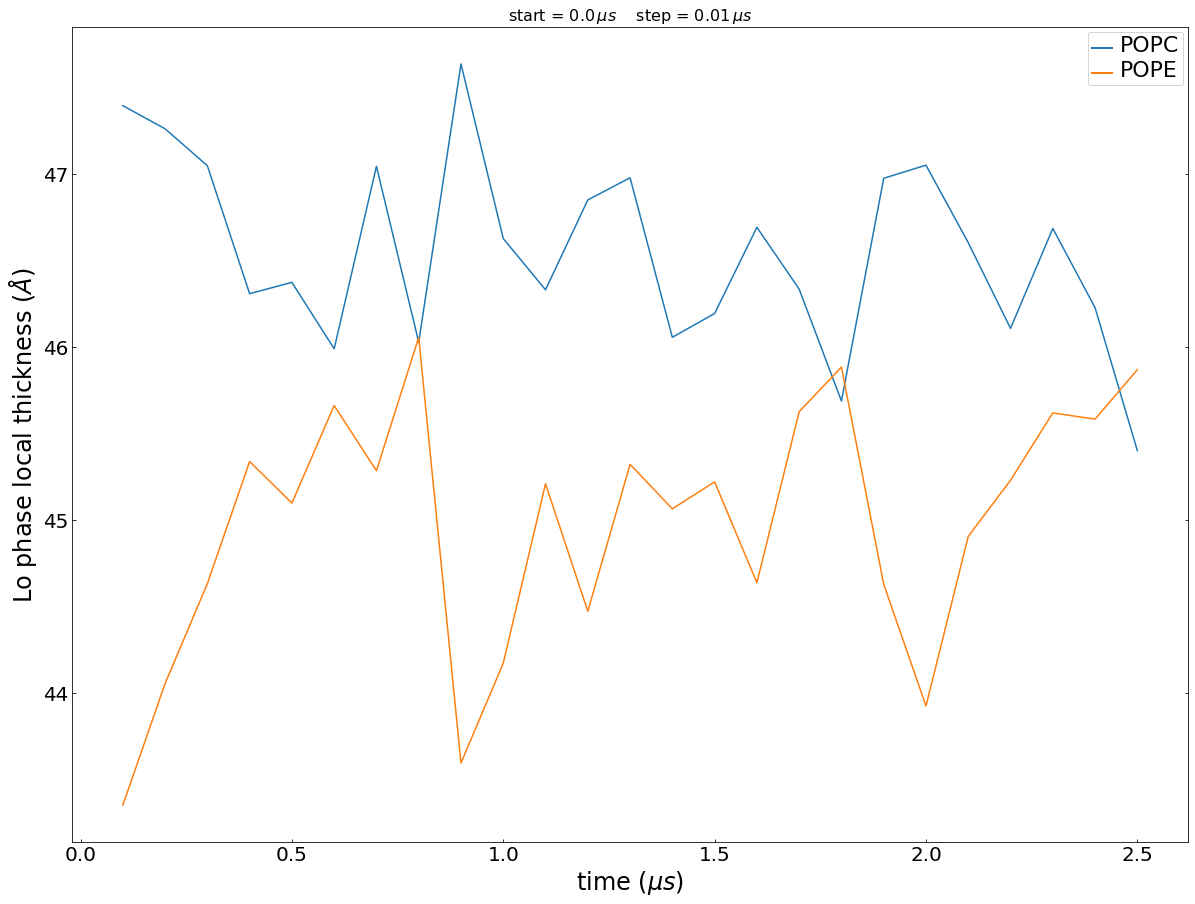

In [45]:
fig, ax = plt.subplots(figsize=(20, 15))


ax.plot(t,thick_t_Lo, label = 'POPC')
ax.plot(t,thick_t_Ld, label = 'POPE')

xmin = 5.0-0.3
xmax = 200.0
#ytop = max(max(thick_t_Lo, thick_t_Ld)) + max(max(thick_t_Lo, thick_t_Ld))/10
#ymin = min(min(thick_t_Lo, thick_t_Ld)) - min(min(thick_t_Lo, thick_t_Ld))/10
#yprint = max(max(thick_t_Lo, thick_t_Ld)) + max(max(thick_t_Lo, thick_t_Ld))/15

plt.xlabel('time ($\mu s$)',fontsize=24)
plt.ylabel('Lo phase local thickness ($\AA$)',fontsize=24)
#plt.ylabel('Lo and Ld phase local thickness ($\AA$)',fontsize=24)


legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(22)
for label in legend.get_lines():
    label.set_linewidth(2)  # the legend line width


ax.set_title('start = %.1lf$\, \mu s$\t step = %.2lf$\, \mu s$' % (t_start_r, tmes_r), fontsize=16)
ax.tick_params(labelsize=20)
ax.xaxis.set_tick_params(direction="in", which="both")
ax.yaxis.set_tick_params(direction="in", right=True, which="both")
    
#plt.xlim(xmin,xmax)
#plt.ylim(ymin,ytop)
#plt.grid(True)

plt.savefig(path_res+'thickness_time'+name+'.pdf', format='pdf',bbox_inches='tight')

# Curvature

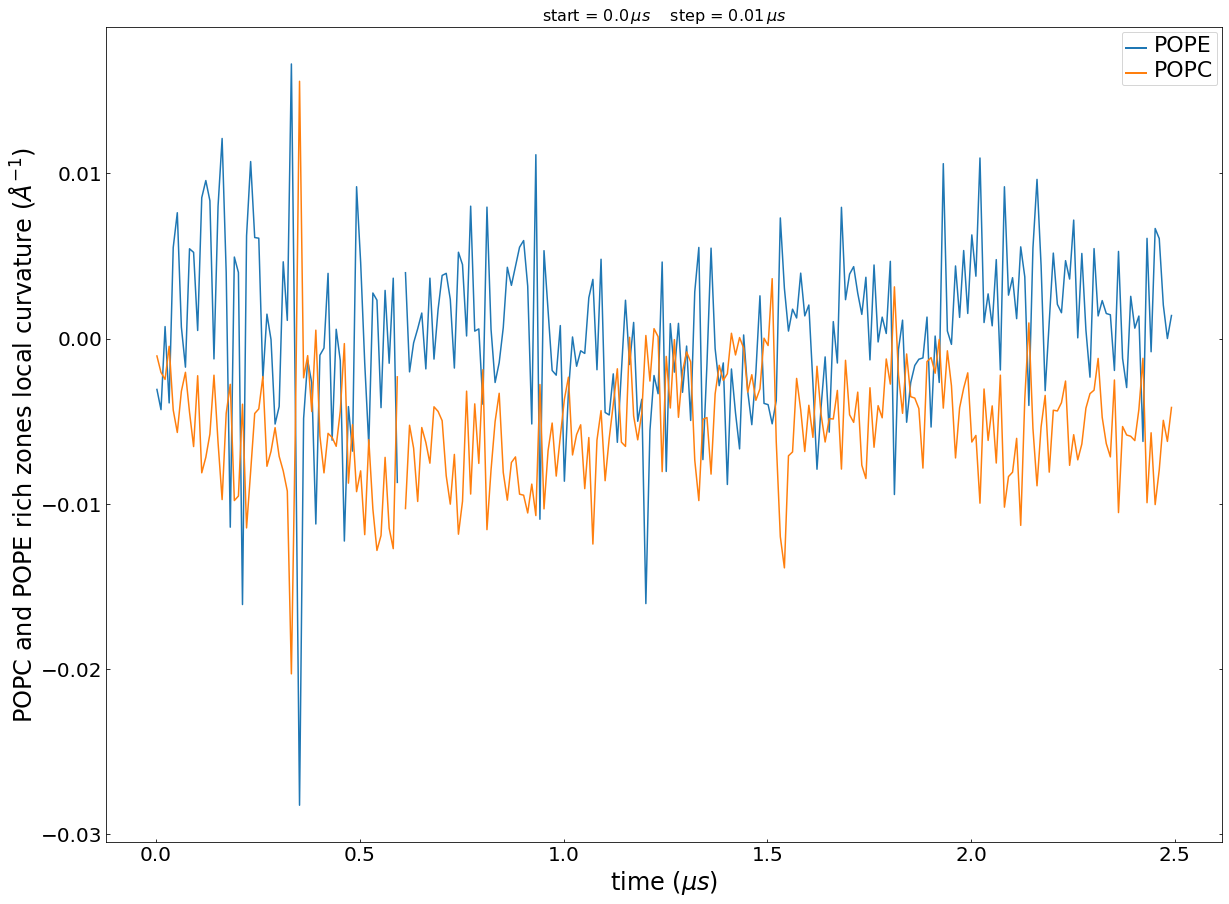

In [23]:
fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(t, C_t_Ld_b, label = 'POPE')
ax.plot(t, C_t_Lo_b, label = 'POPC')

#ytop = max(max(C_t_Lo, C_t_Ld,C_t_bound_Lo)) + max(max(C_t_Lo, C_t_Ld,C_t_bound_Lo))/1.2
#ymin = min(min(C_t_Lo, C_t_Ld)) + min(min(C_t_Lo, C_t_Ld))/2
#yprint = min(min(C_t_Lo, C_t_Ld)) + min(min(C_t_Lo, C_t_Ld))/3

plt.xlabel('time ($\mu s$)',fontsize=24)
plt.ylabel('POPC and POPE rich zones local curvature ($\AA^{-1}$)',fontsize=24)

legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(22)
for label in legend.get_lines():
    label.set_linewidth(2)  # the legend line width

    
ax.set_title('start = %.1lf$\, \mu s$\t step = %.2lf$\, \mu s$' % (t_start_r, tmes_r), fontsize=16)
ax.tick_params(labelsize=20)
ax.xaxis.set_tick_params(direction="in", which="both")
ax.yaxis.set_tick_params(direction="in", right=True, which="both")
    
xmin = 5.0-0.3
xmax = 20.1
#plt.xlim(xmin,xmax)
#plt.ylim(-0.011,0.004)


plt.savefig(path_res+'curvature_time'+name+'.pdf', format='pdf',bbox_inches='tight')

# Domain curvature (in nm$^{-1}$)

In [165]:
np.abs(np.mean(C_t_core_Lo))*10

0.06532759071577296

In [166]:
np.abs(np.mean(C_t_Ld))*10

0.026056444859412112

# Radius of curvature (in nm)

In [167]:
2/np.abs(np.mean(C_t_core_Lo))/10

30.61493586533128

In [168]:
2/np.abs(np.mean(C_t_Ld))/10

76.75644205458673

# Domain GM1 concentration

# Covariances

In [170]:
xprint = min(t)+(max(t)-min(t))/10

In [15]:
l0 = np.load(path_res0+'cov_c_t'+name0+'.npy')
l5 = np.load(path_res5+'cov_c_t'+name5+'.npy')
l10 = np.load(path_res10+'cov_c_t'+name10+'.npy')

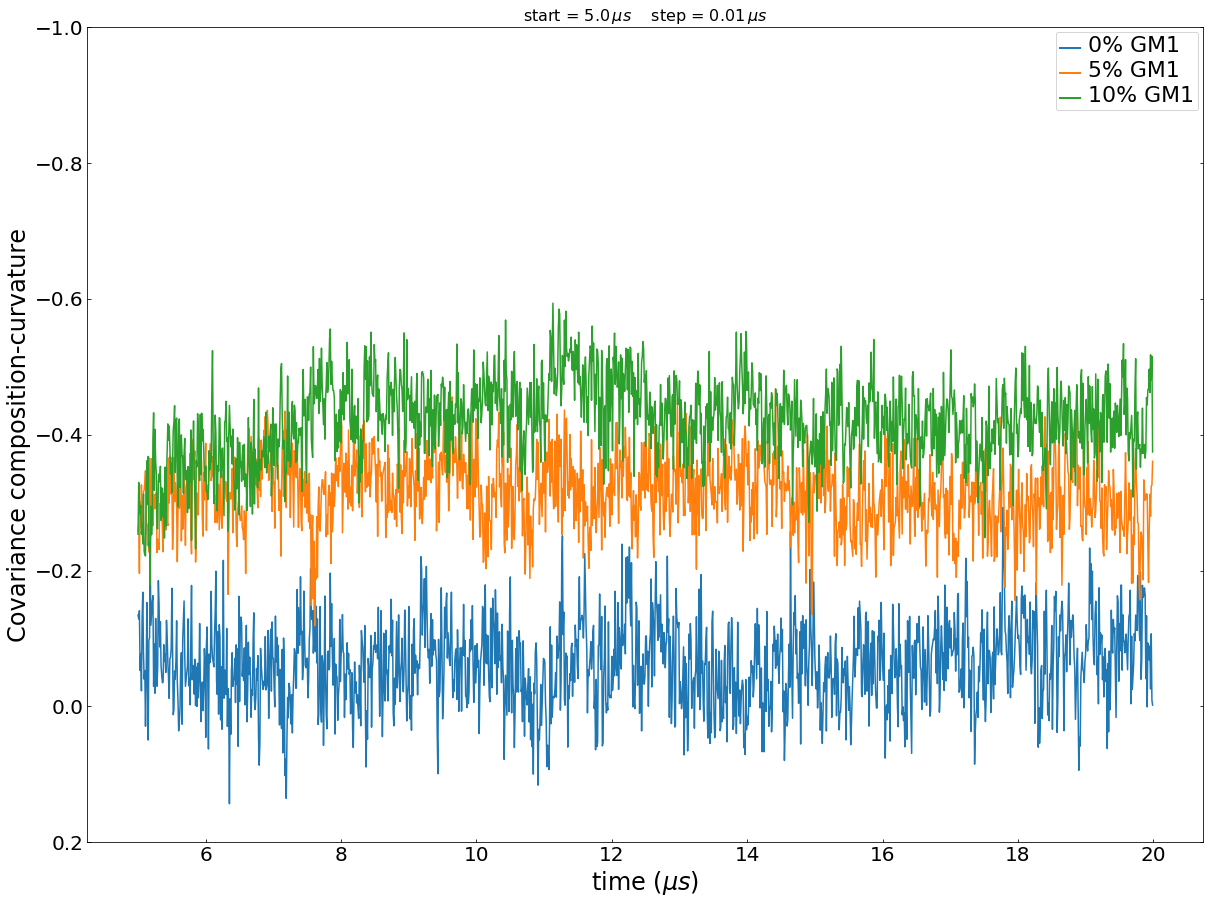

In [213]:
fig, ax = plt.subplots(figsize=(20, 15))

#ax.plot(t, cov_c_t)

ax.plot(t, l0, label = '0% GM1')
ax.plot(t, l5, label = '5% GM1')
ax.plot(t, l10, label = '10% GM1')

legend = ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
#frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize(22)
for label in legend.get_lines():
    label.set_linewidth(2)  # the legend line width

yprint = -0.8

plt.xlabel('time ($\mu s$)',fontsize=24)
plt.ylabel('Covariance composition-curvature',fontsize=24)

ax.set_title('start = %.1lf$\, \mu s$\t step = %.2lf$\, \mu s$' % (t_start_r, tmes_r), fontsize=16)
ax.tick_params(labelsize=20)
ax.xaxis.set_tick_params(direction="in", which="both")
ax.yaxis.set_tick_params(direction="in", right=True, which="both")

xmin = t_start-0.3
xmax = time_simu
#plt.xlim(xmin,xmax)
plt.ylim(0.2,-1)

plt.savefig(pathd+'cov_c_time_bin'+name+'_sup.pdf', format='pdf',bbox_inches='tight')